In [1]:
import sys
import os
import urllib.request

if not os.path.exists('typeIII.pickle'):
  !curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location 'https://api.github.com/repos/mayhd3/DIPC/contents/typeIII.pickle'
if not os.path.exists('qeinput.pickle'):
  !curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location 'https://api.github.com/repos/mayhd3/DIPC/contents/qeinput.pickle'
if os.path.exists('c2db.db'):
  try:
    import ase.db
    import ase.io
  except ImportError:
    !{sys.executable} -m pip install ase asr gpaw
    import ase.db
    import ase.io

In [2]:
import pickle
from itertools import product, compress
from math import hypot
from enum import IntEnum
from io import StringIO
import pandas as pd

print("Collecting type III heterojunctions...")

# Check that a is in ascending order
def ascending(a): return all(
    a[i]<a[i+1] for i in range(len(a)-1)
)

def candidate(left, right):
    def calculation(attr, suffix): # Apply attr to each combination of band energies with given suffix
        return (
            attr(row,band)
                for row in (left,right)
                for band in ('vbm'+suffix,'cbm'+suffix)
        )

    def wrtevac(gaps): # Align band gaps on evac=0
        return (
            next(gaps) - left.evac,
            next(gaps) - left.evac,
            next(gaps) - right.evac,
            next(gaps) - right.evac
        )

    def latpbc(row):
        return compress(
            row.data['results-asr.structureinfo.json']['kwargs']['data']['spglib_dataset']['std_lattice'],
            row.data['structure.json']['1']['pbc']
        )

    def latfit(l, r):
        mina, maxa = min(l[0][0],r[0][0]), max(l[0][0],r[0][0])
        moda = maxa % mina
        if mina < moda+moda:
            moda = mina - moda
        low, far = (
            min(l, r, key=lambda l: l[1][1]),
            max(l, r, key=lambda l: l[1][1])
        )
        quoy, mody = divmod(far[1][1],low[1][1])
        if low[1][1] < mody+mody:
            mody = low[1][1] - mody
            quoy = quoy + 1
        modx = (far[1][0] - quoy*low[1][0]) % low[0][0]
        if low[0][0] < modx+modx:
            modx = low[0][0] - modx
        return moda + hypot(modx,mody)

    functionals = ( # Compare bands calculated with the same functional, prefer G0W0 > HSE > PBE
        (prefix,wrtevac(calculation(getattr,suffix)))
        for prefix,suffix in (('GW','_gw'),('HSE','_hse'),('PBE',''))
        if all(calculation(hasattr,suffix))
    )

    broken = list( # Gaps that are broken and rising
        (prefix,structure)
        for prefix,structure in functionals
        if ascending(structure)
    )

    badtmd = all(( # Materials are TMDs in different phases
        hasattr(left,'class'),
        hasattr(right,'class'),
        getattr(left,'class','').startswith('TMDC'),
        getattr(right,'class','').startswith('TMDC'),
        getattr(left,'class','') != getattr(right,'class','')
    ))

    if all((
        left.thermodynamic_stability_level == 3, # Only accept thermodynamically stable materials
        right.thermodynamic_stability_level == 3, 
        left.is_magnetic == 0, # Do not accept magnetic materials
        right.is_magnetic == 0,
        broken, # At least one functional predicts a type III heterojunction band structure
        left.spgnum == right.spgnum, # Materials must have the same space group
        left.crystal_type == right.crystal_type, # Materials must have the same crystal structure
        not 'C' in left.crystal_type, # Only accept A or AB type crystal structures
        not badtmd # TMDs must have the same phase
    )):
        prefixes,structures = zip(*broken) # Separate titles from band structures 
        depths = (bands[3] - bands[0] for bands in structures) # ΔE = emax - emin
        aratio = left.cell_area/right.cell_area # R = Al / Ar
        (lkps,rkps) = ( # Extract asr k-points
            (
            row.data['results-asr.hse.json']['kwargs']['data']['kvbm'],
            row.data['results-asr.hse.json']['kwargs']['data']['kcbm']
            )
                for row in (left, right)
        )
        return (
            left.formula,
            left.uid,
            right.formula,
            right.uid,
            prefixes,
            structures,
            left.spacegroup,
            left.crystal_type,
            tuple(depths),
            aratio,
            lkps,
            rkps,
            latfit(tuple(latpbc(left)),tuple(latpbc(right)))
        )

Headers = IntEnum('Headers',( # Column titles
        'Left',
        'Left_uid',
        'Right',
        'Right_uid',
        'Calc',
        'Bands_vbm_cbm',
        'Group',
        'Type',
        'ΔE',
        'R',
        'Left_kvbm_kcbm',
        'Right_kvbm_kcbm',
        'Fit'
    ),
    start=0
)

try:
    with open('typeIII.pickle','rb') as pk:
        typeIII = pickle.load(pk)
        print("Loaded from pickle.")
except (OSError, IOError):
    db = ase.db.connect('c2db.db') # Connect to the database
    rows = list(db.select(','.join(( # Find rows that have all of the parameters used to choose candidates
        'evac',
        'thermodynamic_stability_level',
        'is_magnetic',
        'spgnum',
        'crystal_type',
        'has_asr_structureinfo',
        'has_asr_hse'
    ))))
    typeIII = sorted( # Find pairs of rows that could be type III heterojunctions
        filter(
            lambda row: row != None, # Remove pairs that were not candidates
            [candidate(l,r) for l in rows for r in rows] # Take every pair in the selection
        ),
        key = lambda pair: pair[Headers.Fit] # Sort by how well the lattices fit
    )
    print("Loaded from ase db.")
    with open('typeIII.pickle','wb') as pk: # Cache results to make plot changes load faster
        pickle.dump(typeIII, pk)
        print("Dumped to pickle.")

def redirect(images,format): # Capture espresso inputs from stdout in a dict indexed by uid
    old = sys.stdout
    result = StringIO()
    sys.stdout = result
    ase.io.write('-',images,format)
    sys.stdout = old
    return result.getvalue()

print("Generating espresso inputs...")

try:
    with open('qeinput.pickle','rb') as pk:
        qeinput = pickle.load(pk)
        print("Loaded from pickle.")
except (OSError, IOError):
    uids = pd.unique([uid for row in typeIII for uid in (row[Headers.Left_uid],row[Headers.Right_uid])])
    db = ase.db.connect('c2db.db')
    qeinput = {uid:redirect(db.get("uid="+uid).toatoms(),'espresso-in') for uid in uids}
    with open('qeinput.pickle','wb') as pk:
        pickle.dump(qeinput, pk)
        print("Dumped to pickle.")

Loaded from pickle.
Generating espresso inputs...
Loaded from pickle.


In [3]:
from tabulate import tabulate

spgs = pd.unique([row[Headers.Group] for row in typeIII]) # Find which space groups we found pairs from
print("Screening " + str(len(typeIII)) + " type III heterojunctions with " + str(len(qeinput)) + " materials from "+ str(len(spgs)) + " space groups:")

best = [ # The best pair from each spacegroup
    next(row for row in typeIII if row[Headers.Group] == spg)
    for spg in spgs
]

def pretty(row, figs=3, calc=None):
    fmt = "{:"+"."+str(figs)+"f}"
    plus = "{:"+"+"+"."+str(figs)+"f}"
    points = "("+plus+","+plus+") ("+plus+","+plus+")"
    calc = calc or row[Headers.Calc][0]
    return (
        row[i][row[Headers.Calc].index(calc)]
            if i == Headers.Calc else
        points.format(*row[i][row[Headers.Calc].index(calc)])
            if i == Headers.Bands_vbm_cbm else
        fmt.format(row[i][row[Headers.Calc].index(calc)])
            if i == Headers.ΔE else
        points.format(row[i][0][0], row[i][0][1], row[i][1][0], row[i][1][1])
            if i in (Headers.Left_kvbm_kcbm, Headers.Right_kvbm_kcbm) else
        fmt.format(row[i])
            if isinstance(row[i],float) else
        row[i]
        for i in range(len(Headers))
    )

print(tabulate( # Print a table of the best pairs
    [pretty(row,1) for row in best],
    [header.name for header in Headers],
    colalign=("left","right","left","right")
))

Screening 1016 type III heterojunctions with 254 materials from 14 space groups:
Left               Left_uid  Right              Right_uid  Calc    Bands_vbm_cbm            Group    Type          ΔE    R  Left_kvbm_kcbm           Right_kvbm_kcbm            Fit
------  -------------------  -------  -------------------  ------  -----------------------  -------  ----------  ----  ---  -----------------------  -----------------------  -----
MgBr2    MgBr2-bee1987fb4e6  HfI2       HfI2-05a69240794c  PBE     (-6.9,-3.4) (-3.1,-2.5)  P-6m2    AB2-187-bi   4.5  1    (+0.0,+0.0) (+0.0,+0.0)  (+0.3,+0.3) (+0.3,-0.1)    0
Hg2Se2  Hg2Se2-f2919d1605f0  In2I2     I2In2-9ab97b2e26fc  HSE     (-6.1,-5.8) (-5.7,-4.4)  P-1      AB-2-i       1.7  1    (+0.0,+0.0) (+0.0,+0.0)  (+0.1,+0.1) (+0.3,+0.3)    0
HgCl2    HgCl2-ce3ed4728e8f  SnF2       SnF2-d6c3ab6de6b8  PBE     (-7.7,-5.2) (-5.2,-3.6)  P-4m2    AB2-115-dg   4.1  1    (+0.0,+0.0) (+0.0,+0.0)  (+0.5,+0.5) (+0.0,+0.0)    0
NiSe2    NiSe2-c1ffa88ee5

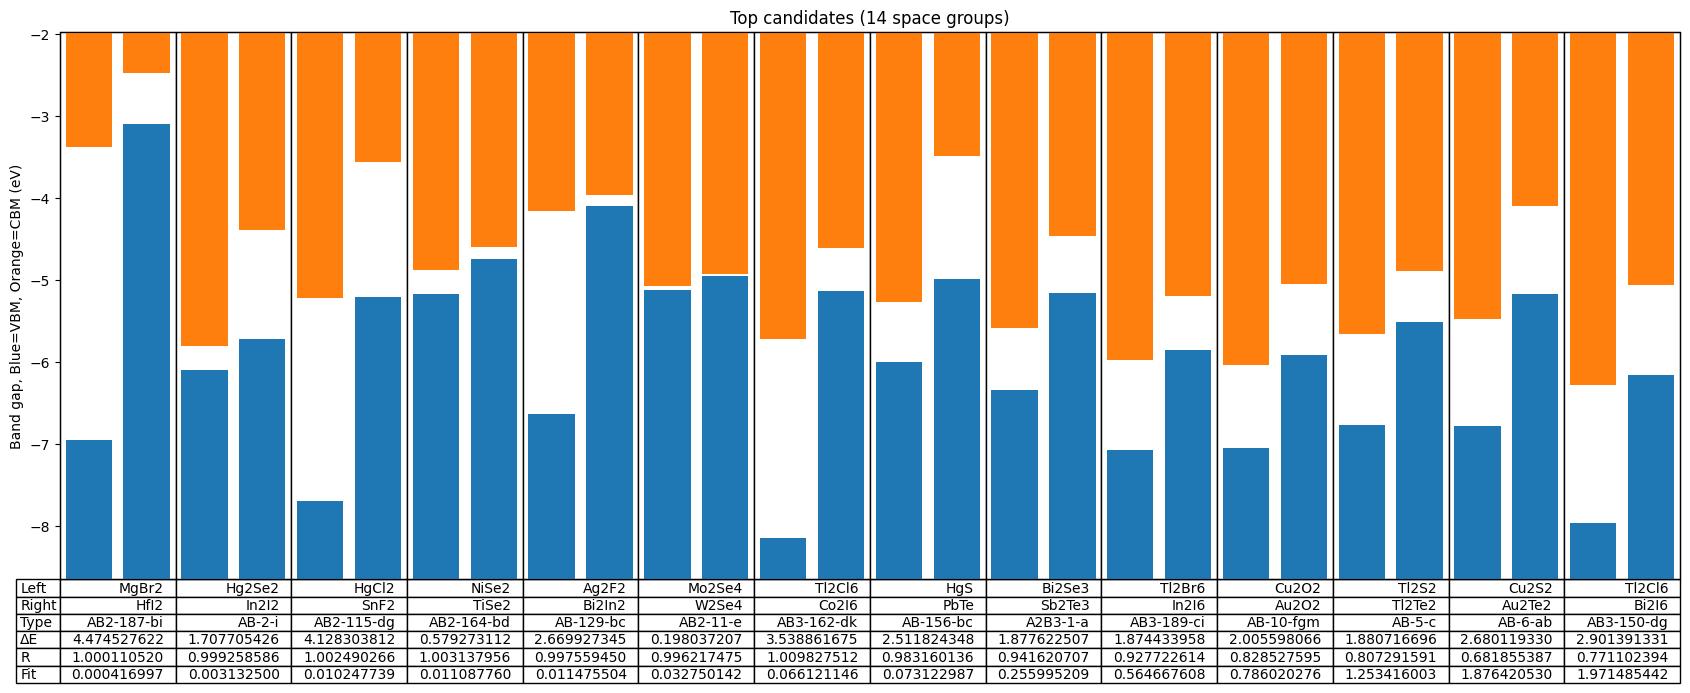

In [4]:

import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

table_headers = itemgetter( # Which headers to display in the table
    Headers.Left,
    Headers.Right,
    Headers.Type,
    Headers.ΔE,
    Headers.R,
    Headers.Fit
)

def bands_with_table(pairs,figs,calc=None): # Plot each pair of candidates, with bars for the band gaps, and a table for other stats
    ax = plt.subplot(label=str(id(pairs)))
    ax.margins(x=0)

    flatx = range(len(pairs)*2)

    if(not flatx): # Empty graph
        return

    [leftvbm, leftcbm, rightvbm, rightcbm] = np.transpose([
        pair[Headers.Bands_vbm_cbm][pair[Headers.Calc].index(calc or pair[Headers.Calc][0])]
        for pair in pairs
    ])

    emin = np.amin(leftvbm) - .5
    emax = np.amax(rightcbm) + .5

    leftx = flatx[::2]
    ax.bar(leftx, leftvbm-emin, bottom=emin, color='C0')
    ax.bar(leftx, leftcbm-emax, bottom=emax, color='C1')
    #ax.bar(leftx, leftvbm-leftcbm, bottom=leftcbm)

    rightx = flatx[1::2]
    ax.bar(rightx, rightvbm-emin, bottom=emin)
    ax.bar(rightx, rightcbm-emax, bottom=emax)
    #ax.bar(rightx, rightvbm-rightcbm, bottom=rightcbm)

    ax.set_xlim(-.5,len(flatx)-.5)
    ax.set_ylim(emin,emax)

    plt.xticks([],[])

    table = plt.table(
        cellText=np.transpose([table_headers(tuple(pretty(pair,figs,calc))) for pair in pairs]),
        rowLabels=table_headers(tuple(header.name for header in Headers)),
        loc='bottom'
    )
    table.auto_set_font_size(False)
    table.set_fontsize('medium')

    plt.table(
        cellText=[['' for x in leftx]],
        bbox=[0,0,1,1]
    )

    plt.ylabel('Band gap, Blue=VBM, Orange=CBM (' + ('',calc)[bool(calc)] + ' '*bool(calc) + 'eV)')

plt.figure(figsize=(17,7),dpi=100)
bands_with_table(best,9)
plt.title("Top candidates (" + str(len(spgs)) + " space groups)")
plt.tight_layout()
plt.show()

In [5]:
import ipywidgets as widgets

radio = widgets.RadioButtons(
    options=('GW','HSE','PBE'),
    value='PBE',
    description='Calculation:',
    style={'description_width': 'initial'}
)

ddown = widgets.Dropdown(
    options=spgs,
    description='Space group:',
    style={'description_width': 'initial'}
)

slide = widgets.IntRangeSlider(
    value=(0,20),
    description='Candidate indices:',
    style={'description_width': 'initial'}
)

def update_slide_max(event):
    slide.max = len(spacegroup)
    upper = min(slide.value[1],slide.max)
    lower = min(slide.value[0],upper)
    slide.value = (lower,upper)

spacegroup = None
def update_spacegroup(event):
    global spacegroup
    spacegroup = [row for row in functional if row[Headers.Group] == ddown.value] # Rows in this group
    update_slide_max(event)

functional = None
def update_functional(event):
    global functional
    functional = [row for row in typeIII if radio.value in row[Headers.Calc]]
    ddown.options = pd.unique([row[Headers.Group] for row in functional])
    update_spacegroup(event)

update_functional(None)
ddown.observe(update_spacegroup, names='value')
radio.observe(update_functional, names='value')

bands = widgets.Button(description='VBM, CBM')
ratio = widgets.Button(description='ΔE, R')
combo = widgets.Combobox(
    placeholder='uid',
    options=tuple(qeinput.keys()),
    description="Espresso input:",
    style={'description_width': 'initial'},
)

qebox = widgets.Textarea(
    placeholder='pwi',
    disabled=True
)

def update_qebox(event):
    if(combo.value in qeinput.keys()):
        qebox.value = qeinput[combo.value]
        qebox.rows = qebox.value.count('\n') + 1

combo.observe(update_qebox, names='value')
matpl = widgets.Output()
table = widgets.HTML()

def update_matpl_table(button):
    with matpl:
        matpl.clear_output(wait=True)
        top = spacegroup[slide.value[0]:slide.value[1]] # Top 20 rows in this space group
        plt.figure(figsize=(17,7),dpi=100)
        if button==bands:
            bands_with_table(top,6,radio.value)
        if button==ratio:
            plt.scatter(
                x=[s[Headers.ΔE][s[Headers.Calc].index(radio.value)] for s in top],
                y=[s[Headers.R] for s in top]
            )
            for s in top: # Label scatter plot points with formulas
                plt.annotate(s[Headers.Left]+","+s[Headers.Right],(s[Headers.ΔE][s[Headers.Calc].index(radio.value)],s[Headers.R]))
            plt.xlabel(Headers(Headers.ΔE).name + " (eV)")
            plt.ylabel(Headers(Headers.R).name + " (1)")

        plt.title(ddown.value + " (top " + str(slide.value[0]) + "-" + str(slide.value[1]) + " of " + str(len(spacegroup)) + " candidates)")
        plt.tight_layout()
        plt.show()

        for row in range(len(top)):
            pair = list(top[row])

            pair[Headers.Left_uid] = '<a target="_blank" href="https://cmrdb.fysik.dtu.dk/c2db/row/' + \
                pair[Headers.Left_uid] + '">' + \
                pair[Headers.Left_uid] + '</a>'

            pair[Headers.Right_uid] = '<a target="_blank" href="https://cmrdb.fysik.dtu.dk/c2db/row/' + \
                pair[Headers.Right_uid] + '">' + \
                pair[Headers.Right_uid] + '</a>'
            top[row] = pair

        table.value = \
            """
            <style>
            tr:hover {
                background-color: gainsboro !important;
            }
            tr {
                background-color: white !important;
            }
            table tr td {
                border-left: 1px solid gainsboro !important;
                border-right: 1px solid gainsboro !important;
                font-family: monospace !important;
            }
             table {
              border-spacing: 0 !important;
            }
            thead tr th {
              border-bottom: 1px solid gainsboro !important;
            }
            </style>
            """ + tabulate(
                [pretty(pair,3,radio.value) for pair in top],
                [header.name for header in Headers],
                tablefmt="unsafehtml"
            )

bands.on_click(update_matpl_table)
ratio.on_click(update_matpl_table)

display(radio, ddown, slide, bands, ratio, matpl, table, combo, qebox)

RadioButtons(description='Calculation:', index=2, options=('GW', 'HSE', 'PBE'), style=DescriptionStyle(descrip…

Dropdown(description='Space group:', options=('P-6m2', 'P-1', 'P-4m2', 'P4/nmm', 'P-3m1', 'P2_1/m', 'P-31m', '…

IntRangeSlider(value=(0, 20), description='Candidate indices:', max=443, style=SliderStyle(description_width='…

Button(description='VBM, CBM', style=ButtonStyle())

Button(description='ΔE, R', style=ButtonStyle())

Output()

HTML(value='')

Combobox(value='', description='Espresso input:', options=('MgBr2-bee1987fb4e6', 'HfI2-05a69240794c', 'Hg2Se2-…

Textarea(value='', disabled=True, placeholder='pwi')